In [75]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
import scipy.ndimage
import seaborn as sns

def imshow(img, ax=None, title="", bgr=True):
    # since plt and cv2 have different RGB sorting
    if bgr:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    if ax == None:
        plt.imshow(img.astype(np.uint8))
        plt.axis("off")
        plt.title(title)
    else:
        ax.imshow(img.astype(np.uint8))
        ax.set_axis_off()
        ax.set_title(title)
        
plt.rcParams["figure.figsize"] = (12,6)

## Image Stitching

When matching to images, and even to merge into one.  
__Detection__ identify the interest points  
__Description__ extract __feature vector__ around each interest point  
__Matching__ determine correspondence between descriptors in two views

The goal is to detect the same points in both images, the number of points must be generated in each image independently, and must have a sufficient number for comparison, while at the same time not too many, which makes the algorithm slow. 

#### What are good characteristics for a interest point
Must have somewhat unique texture in the local sense  
Large contrast changes, i.e. gradients  
Edge is less useful since line segments can be localized on any place with the same orientation (aperture problem)  
Therefore, we need at least two different orientations, which can be reliably matched

### Harris Corner Detector
"Corner like" patch can be reliably matched

We should easily recognize the corner "point" by looking through a small window, where there should have a large change in intensity in all directions. 

#### Weighed summed square difference
$$E_{WSSD}(u,v) = \sum_x \sum_y w(x,y)[I(x+u, u+v) - I(x,y)]^2$$
where $w: \mathbb N^2 \rightarrow \mathbb R$ is the weighted function, for example indicator $\mathbb I((x,y) \text{ in window})$, or 2-D Gaussian. 

Them, fit $I(x+u, y+v)$ by a first-order Taylor series expansion about $x,y$: 
$$I(x+u, y+v)\approx I(x,y) + u\cdot \frac{\partial I}{\partial x}(x,y) + v\cdot \frac{\partial l}{\partial y}(x,y)$$
Then, we can approximate $I$ by a series of polynomials, so that we can plugging in for $E_{WSSD}$

$$\begin{align}
E_{WSSD}(u,v) &= \sum_x \sum_y w(x,y)[I(x+u, u+v) - I(x,y)]^2\\
&\approx \sum_x\sum_y w(x,y)(I(x,y) + u\cdot I_x + v\cdot I_y - I(x,y))^2\\
&= \sum_x\sum_y w(x,y)(u^2I_x^2 + 2u\cdot v\cdot I_x\cdot I_y + v^2I_y^2)\\
&= \sum_x \sum_y w(x,y) \cdot \begin{bmatrix}u&v\end{bmatrix}
\begin{bmatrix}I_x^2&I_x\cdot I_y\\I_x\cdot I_y &I_y^2\end{bmatrix}
\begin{bmatrix}u\\v\end{bmatrix}\\
\text{Let }M &:= \sum_x\sum_y w(x,y)\begin{bmatrix}I_x^2&I_x\cdot I_y\\I_x\cdot I_y &I_y^2\end{bmatrix}\\
&= \begin{bmatrix}u&v\end{bmatrix}
M
\begin{bmatrix}u\\v\end{bmatrix}
\end{align}$$

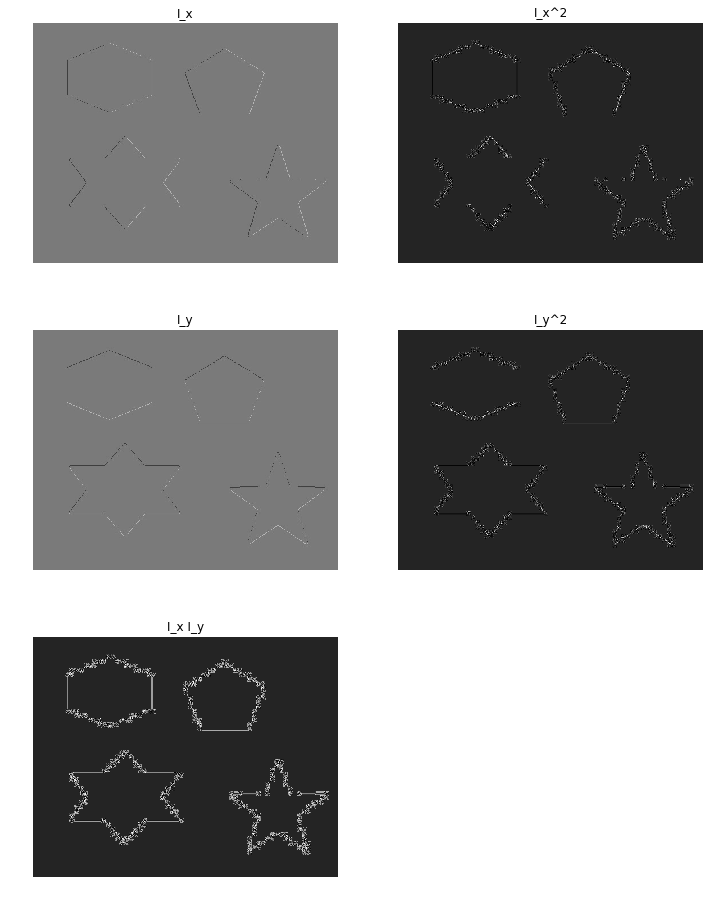

In [44]:
img = cv2.imread("../assets/Corners.jpg", cv2.IMREAD_GRAYSCALE)
fig, axs = plt.subplots(3, 2, figsize=(12, 16))
img_v = cv2.filter2D(img, -1, np.array([[-1, 1]]), delta=122)
img_h = cv2.filter2D(img, -1, np.array([[-1], 
                                        [1]]), delta=122)
imshow(img_v, axs[0][0], "I_x")
imshow(img_h, axs[1][0], "I_y")
imshow(img_v * img_v, axs[0][1], "I_x^2")
imshow(img_h * img_h, axs[1][1], "I_y^2")
imshow(img_v * img_h , axs[2][0], "I_x I_y")
axs[2][1].set_axis_off()

Note that $M$ is independent of $u,v$.

Consider using an indicator weight function, then $M = \begin{bmatrix}\sum_{x,y} I_x^2 &\sum_{x,y} I_x\cdot I_y\\\sum_{x,y} I_x\cdot I_y &\sum_{x,y} I_y^2\end{bmatrix}$ defines the shape. Generally, $E_{WSSD}(u,v)$ will be a ellipse

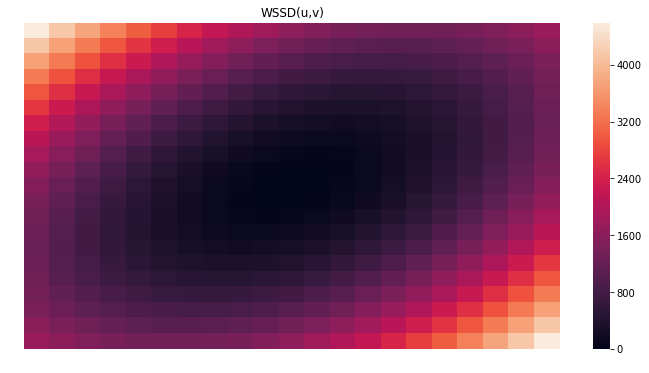

In [79]:
patch = img[50: 100, 50: 100]
I_x = cv2.filter2D(patch, -1, np.array([[-1, 1]]))
I_y = cv2.filter2D(patch, -1, np.array([[-1], [1]]))

M = np.array([[np.sum(I_x ** 2), np.sum(I_x * I_y)], 
              [np.sum(I_x * I_y), np.sum(I_y ** 2)]])
result = np.zeros((21, 21))
for u in range(-10, 11):
    for v in range(-10, 11):
        vec =  np.array([[u/10, v/10]])
        result[u+10, v+10] = vec @ M @ vec.T
ax = sns.heatmap(result)
ax.set_axis_off()
ax.set_title("WSSD(u,v)");

Note that $M$ is symmetric $2\times 2$ matrix and is diagonalizable, i.e. $M = V diag(\lambda_1, \lambda_2), V^{-1}$, and $\lambda_{\min}^{-1/2}, \lambda_{max}^{-1/2} \propto$ length of the radii of the ellipse and indicate the direction of of slowest change and fastest change, respectively. 

Then, a perpendicular corner will have large lambdas and $\lambda_1 \approx \lambda_2$, for edges, $\lambda_a >> \lambda_b$, for "flat" region, lambdas are small

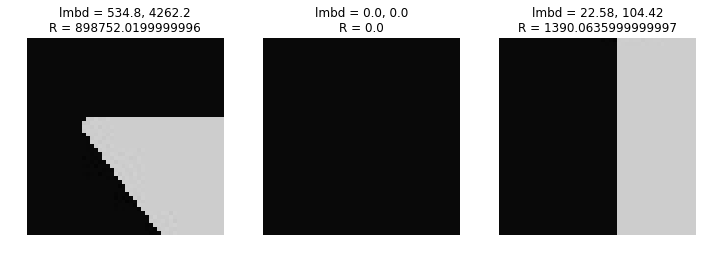

In [123]:
patches = [img[220: 270, 50: 100], img[:50, : 50], img[70: 120, 30: 80]]
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    patch = patches[i]
    I_x = cv2.filter2D(patch, -1, np.array([[-1, 1]]))
    I_y = cv2.filter2D(patch, -1, np.array([[-1], [1]]))
    
    M = np.array([[np.sum(I_x ** 2), np.sum(I_x * I_y)], 
                  [np.sum(I_x * I_y), np.sum(I_y ** 2)]])
    eig = np.round(np.linalg.eigvals(M), 2)
    R = eig[0] * eig[1] - 0.06*(eig[0] + eig[1])**2
    imshow(patch + 10, axs[i], "lmbd = " + str(eig[0]) + ", " + str(eig[1]) + "\nR = " + str(R))